In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Generation of Synthetic data

### Signal : discretization

In [107]:
#load signal
signal = np.loadtxt("signal.txt").flatten()

In [108]:
N = len(signal)

In [109]:
T_min = 1
T_max = 1000
T = []
for i in range(1,N+1):
    T.append(T_min*np.exp(-(i-1)*np.log(T_min/T_max)/(N-1)))

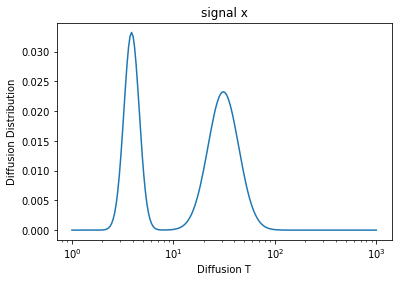

In [110]:
plt.xscale('log')
plt.plot(T,signal)
plt.title("signal x")
plt.xlabel("Diffusion T")
plt.ylabel("Diffusion Distribution")
plt.show()

### Simulate noisy data

In [133]:
#create t using regular sampling strategy
M = 50
t_min = 0
t_max = 1.5
t = []
for i in range(1,M+1):
    t.append(t_min+(i-1)/(M-1)*(t_max-t_min))

In [134]:
#construct Matrix K
K = np.zeros((M,N))
for m in range(M):
    for n in range(N):
        K[m,n] = np.exp(-T[n]*t[m])

In [135]:
#simulate the noisy data
z = K@signal
z1 = z[0]
sigma = 0.01*z1
W = np.random.multivariate_normal(mean = [0]*M, cov = (sigma**2)*np.eye(M))

y = K@signal + W

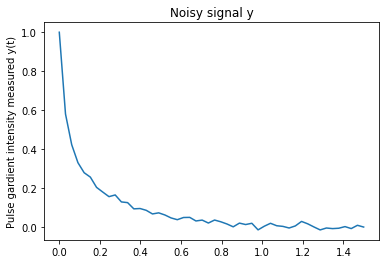

In [136]:
plt.plot(t,y)
plt.title("Noisy signal y")
plt.ylabel("Pulse gardient intensity measured y(t)")
plt.show()

## Comparison of regularizetion strategies

### 1. Smoothness prior

In [23]:
#D = np.roll(np.eye(200), 1, axis=0)
#create matrix D
L = [1] + [0]*(N-2) + [-1]
L_arr = np.array(L)
D = L_arr
for n in range(N):
    L = np.roll(L,1)
    D = np.vstack((D,L))

We define a set of candidate values for $\beta$. For each value of $\beta$ we compute the optimal signal solution $\hat{x}$ and the correspondant error.

In [25]:
betas = [2**i for i in range(-6,3)]
errors = []
for beta in betas:
    x_hat = np.linalg.inv(K.T@K + beta*D.T@D)@K.T@y
    error = np.linalg.norm(x_hat - signal)**2 / np.linalg.norm(signal)**2
    errors.append(error)

the best value of $\beta$ is the one that yields the lowest error value.

In [31]:
best_beta = betas[np.argmin(errors)]
x_hat = np.linalg.inv(K.T@K + best_beta*D.T@D)@K.T@y

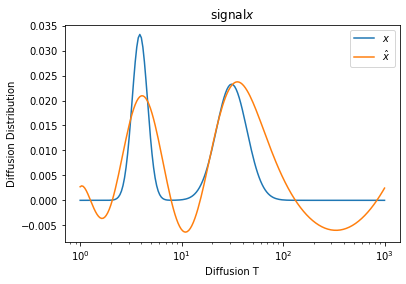

In [34]:
plt.figure()
plt.xscale('log')
plt.plot(T,signal, label = "$x$")
plt.plot(T,x_hat, label = "$\hat{x}$")



lines = plt.gca().get_lines()
include = [0,1]
legend1 = plt.legend([lines[i] for i in include],[lines[i].get_label() for i in include], loc=1)

plt.title("signal$x$")
plt.ylabel('Diffusion Distribution')
plt.xlabel('Diffusion T')
plt.show()

### Smoothness prior + constraints

Pro tip : np.clip for the projection in [x_min,x_max]

In [115]:
def solver(signal,y, beta):
    #determine nu
    Hess =  K.T@K + beta*D.T@D
    nu = max(np.abs(np.linalg.eigvals(Hess)))
    #initialize x
    x_min = min(signal)
    x_max = max(signal) 
    x = [0.5*(x_min+x_max)]*len(signal)
    x = np.array(x)
    #initialize gamma, delta, lambda
    gamma = 1.999/nu
    delta=2-nu*gamma/2
    lambd = 0.99*delta
    
    #stopping criterions
    max_iter = 100
    error = 1e6
    
    #initialize number of iteration
    iteration = 1
    while iteration<max_iter and error>1e-6:
        y_n = x - gamma*(K.T@K@x - K.T@y + beta*D.T@D@x)
        #compute p_c
        p_c = []
        for i in range(len(x)):
            if x[i]<x_min:
                p_c.append(x_min)
            elif x[i]>x_max:
                p_c.append(x_max)
            else:
                p_c.append(y_n[i])
        p_c = np.array(p_c)
        
        error = np.linalg.norm(lambd*(p_c - x))**2/np.linalg.norm(x)**2
        x = x + lambd*(p_c - x)
        iteration+=1
    return x, error

In [116]:
betas = [2**i for i in range(-6,3)]
best_beta = min(betas, key = lambda c : solver(signal, y, c)[1])

In [117]:
x_hat, err = solver(signal, y, best_beta)

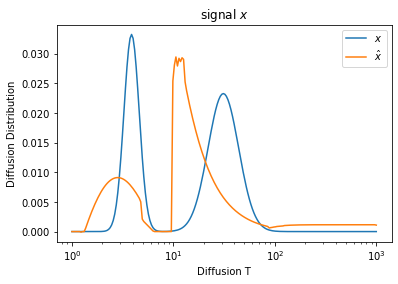

In [118]:
plt.figure()
plt.xscale('log')
plt.plot(T,signal, label = "$x$")
plt.plot(T,x_hat, label = "$\hat{x}$")



lines = plt.gca().get_lines()
include = [0,1]
legend1 = plt.legend([lines[i] for i in include],[lines[i].get_label() for i in include], loc=1)

plt.title("signal $x$")
plt.ylabel('Diffusion Distribution')
plt.xlabel('Diffusion T')
plt.show()

### Sparsity prior

In [126]:
def solver(signal,y, beta):
    #determine nu
    Hess =  K.T@K + beta*D.T@D
    nu = max(np.abs(np.linalg.eigvals(Hess)))
    #initialize x
    x_min = min(signal)
    x_max = max(signal) 
    x = [0.5*(x_min+x_max)]*len(signal)
    x = np.array(x)
    #initialize gamma, delta, lambda
    gamma = 1.999/nu
    delta=2-nu*gamma/2
    lambd = 0.99*delta
    
    #stopping criterions
    max_iter = 100
    error = 1e6
    
    #initialize number of iteration
    iteration = 1
    while iteration<max_iter and error>1e-6:
        y_n = x - gamma*K.T@(K@x - y)
        #compute prox
        prox = []
        for i in range(len(x)):
            prox.append(np.sign(y_n[i])*max([abs(y_n[i])-gamma*beta,0]))
        prox = np.array(prox)
    
        error = np.linalg.norm(lambd*(prox - x))**2/np.linalg.norm(x)**2
        x = x + lambd*(prox - x)
        iteration+=1
    return x, error

In [127]:
betas = [2**i for i in range(-6,3)]
best_beta = min(betas, key = lambda c : solver(signal, y, c)[1])

In [128]:
x_hat, err = solver(signal, y, best_beta)

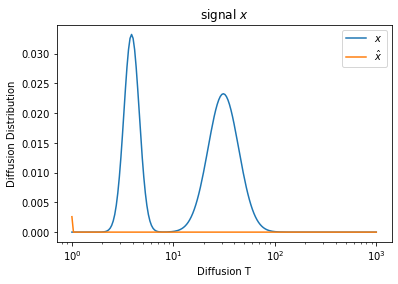

In [125]:
plt.figure()
plt.xscale('log')
plt.plot(T,signal, label = "$x$")
plt.plot(T,x_hat, label = "$\hat{x}$")



lines = plt.gca().get_lines()
include = [0,1]
legend1 = plt.legend([lines[i] for i in include],[lines[i].get_label() for i in include], loc=1)

plt.title("signal $x$")
plt.ylabel('Diffusion Distribution')
plt.xlabel('Diffusion T')
plt.show()

Indicator <br>
I think a binary grid is better : something like [2**i for i in range(-6,3)]
simply xmin = min(x_bar), xmax = max(x_bar)

max(np.abs(np.linalg.eigvals(Hess)))
lambda = 0.99*delta

hello, sorry i didn't hear when you talked about choosing lambda and gamma, in terms of nu. nu is max(np.abs(np.linalg.eigvals(Hess))), right? so how do we choose lambda and gamma? yess

gamma = 1.999/nu for ex

**3 errors in 3 slides which i took photos of them so check them**

error value : for the 1st one something like 1.25 for best beta if i remember well

For a general y Pc(y) = max(min(y,xmax),xmin)